In [1]:
%%javascript
IPython.OutputArea.prototype._should_scroll = function(lines) {
    return false;
}

<IPython.core.display.Javascript object>

# Viscous disc evolution 

In the lectures, we derived the viscous diffusion equation for the surface density in a Keplerian disc:
\\[\frac{\partial\Sigma}{\partial t} = \frac{3}{r} \frac{\partial}{\partial r}\left(r^{1/2} \frac{\partial}{\partial r}\left(r^{1/2} \bar\nu \Sigma\right)\right).\\]
In this notebook, we are going to visually explore some solutions, where we take the viscosity \\(\bar \nu\\) to be a constant.

## Viscously spreading ring

We first look at the famous solution for the viscously spreading ring. On Exercise sheet 5, we (painstakingly!) derived the solution:
\\[\Sigma(\tau, x) = \frac{M_0}{4\pi r_0^2 \tau} x^{-1/4} \exp\left(-\frac{1+x^2}{4\tau}\right) I_{1/4}\left(\frac{x}{2\tau}\right),\\]
with \\(x=r/r_0\\) and \\(\tau =3\bar\nu t/r_0^2\\). We will use the \\(\alpha\\) prescription for the viscosity and write \\(\bar\nu = \alpha c_s(r_0) H(r_0)\\), where the sound speed and the scale height are evluated at \\(r_0\\) to ensure the viscosity is constant. In the figure below, you can vary \\(\alpha\\) to look at different viscosities and move the time slider to took at the time evolution.

FloatLogSlider(value=10.0, continuous_update=False, description='$\\Omega t$:', min=1.0, readout_format='.3f')

Output()

FloatLogSlider(value=0.003, continuous_update=False, description='$\\alpha$:', max=-1.6989700043360187, min=-3…

Output()

<IPython.core.display.Javascript object>


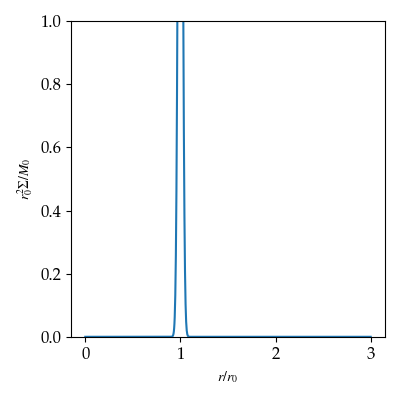

In [2]:
%matplotlib notebook
import numpy as np
import matplotlib.pyplot as plt
from scipy.special import ive
from IPython.display import display, update_display, HTML
import ipywidgets as widgets

# Try and make plots look nice
plt.rcParams["font.family"] = 'serif'
plt.rcParams["mathtext.fontset"] = 'stix'
plt.rcParams["font.serif"] = 'Palatino'
plt.rcParams['pdf.fonttype'] = 42
plt.rc('xtick', labelsize='large')
plt.rc('ytick', labelsize='large')

w_time = widgets.FloatLogSlider(
    value=10.0,
    base = 10,
    min=np.log10(10.0),
    max=np.log10(10000),
    step=0.1,
    description=r'$\Omega t$:',
    disabled=False,
    continuous_update=False,
    orientation='horizontal',
    readout=True,
    readout_format='.3f',
)

w_alpha = widgets.FloatLogSlider(
    value=0.003,
    min=np.log10(0.0004),
    max=np.log10(0.02),
    step=0.1,
    description=r'$\alpha$:',
    disabled=False,
    continuous_update=False,
    orientation='horizontal',
    readout=True,
    readout_format='.4f',
)

# Display eccentricity slider
output = widgets.Output()
display(w_time, output)
display(w_alpha, output)

def ring_sigma(t, r, nu):
    tau = 3*t*nu
    return 0.25*np.power(r, -0.25)*np.exp(-0.25*(1 + r*r - 2*r)/tau)*ive(0.25, 0.5*r/tau)/(np.pi*tau)

fig = plt.figure(figsize=(4,4),num='Viscously spreading ring')
ax = plt.gca()

alpha = 0.003
nu = alpha*0.05*0.05
ring_time = 10.0
r = np.linspace(1.0e-3, 3.0, 1000)

ax.set_xlabel(r'$r/r_0$')
ax.set_ylabel(r'$r_0^2\Sigma/M_0$')
ax.set_ylim([0,1])
line, = ax.plot(r, ring_sigma(ring_time, r, nu));

plt.tight_layout()
    
def on_value_change_time(change):
    with output:
        global ring_time
        ring_time = change['new']
         
        line.set_data(r, ring_sigma(ring_time, r, alpha*0.05*0.05));

        #ax.relim()
        #ax.autoscale()
        #plt.tight_layout()

def on_value_change_alpha(change):
    with output:
        global alpha
        alpha = change['new']
         
        line.set_data(r, ring_sigma(ring_time, r, alpha*0.05*0.05));

        #ax.relim()
        #ax.autoscale()
        #plt.tight_layout()
 
w_time.observe(on_value_change_time, names='value')
w_alpha.observe(on_value_change_alpha, names='value')



1. Set \\(\alpha=0.005\\), and find the time when the peak of the surface density is closest to \\(0.6\\). Now change to \\(\alpha=0.01\\). How far back in time do you have to go for the surface density peak to be at \\(0.6\\)? Could you have predeicted that from the analytical solution?
2. (Hard!) In the lectures we occasionally use the approximation that the accretion velocity \\(v_r \sim -\bar\nu/r\\) . How long would it take for a gas parcel to make it from \\(r=r_0\\) to \\(r=0\\)? You may assume the accretion velocity is constant. From the figure, can you determine roughly when material has definitely made it to the inner boundary? Why do you think there is such a strong discrepancy between the two approaches?

## General solution

Now we turn to an arbitrary initial condition. This makes it necessary to turn to a fully numerical solution. In the figure below, we fix \\(\bar\nu = 10^{-5}\\) with a radial domain \\(0.01 \leq r/r_0 \leq 9\\). The number of grid points is 100. In the text box, you can enter an arbitrary initial surface density profile as a function of \\(x=r/r_0\\). You can use the exponential function \\(\exp\\), trigoniometric functions \\(\sin,\cos\\), as well as powers using the \\(**\\) symbol (i.e. \\(x \\)\\(**\\)\\(2 = x^2\\)). As an example, the solution studied in question 4 of Exercise sheet 5 is shown ('Simple Accretion'). Move the time slider to see how the solution evolves.  

Text(value='exp(-x*x)', continuous_update=False, description='$\\Sigma_0$:', placeholder='Type a formula')

Output()

FloatLogSlider(value=10.0, continuous_update=False, description='$\\Omega t$:', max=7.0, min=1.0, readout_form…

Output()

<IPython.core.display.Javascript object>


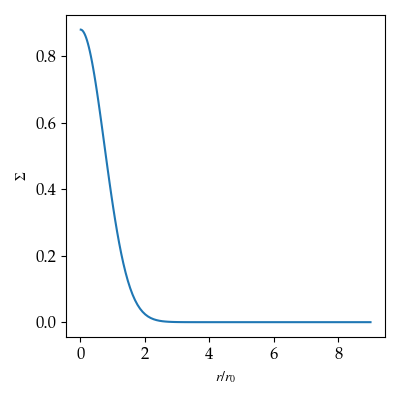

In [3]:
from scipy.sparse import dia_matrix
from scipy.sparse.linalg import spsolve
from numpy import sin, cos, exp

w_form = widgets.Text(
    value='exp(-x*x)',
    placeholder='Type a formula',
    description=r'$\Sigma_0$:',
    disabled=False,
    continuous_update=False
)

w_time2 = widgets.FloatLogSlider(
    value=10.0,
    base = 10,
    min=np.log10(10.0),
    max=np.log10(10000000),
    step=0.1,
    description=r'$\Omega t$:',
    disabled=False,
    continuous_update=False,
    orientation='horizontal',
    readout=True,
    readout_format='.3f',
)
display(w_form, output)
display(w_time2, output)

n = 100

nu = 1.0e-5
dt = 0.01/nu

u = np.linspace(0.1, 3, n)
du = u[1] - u[0]

z = 3.0*dt*nu/(4*u*u*du*du)

a = 1 + 2*z
b = np.roll(-z, 1)
c = np.roll(-z, -1)

# Zero torque boundaries
a[0] = a[0] - z[0]*(u[0] - du)/u[0]
#a[-1]= a[-1]- z[-1]*(u[-1] + du)/u[-1]

# Closed boundaries
#a[0] = a[0] - z[0]
a[-1] = a[-1] - z[-1]

data = np.array([c, a, b])
offsets = np.array([-1, 0, 1])
A = dia_matrix((data, offsets), shape=(n, n)).tocsc()

form_str = "exp(-x*x)"

def run_until(t_end):
    Sigma0 = lambda x: eval(form_str)
    Sigma = Sigma0(u*u)
    t = 0.0
    while (t < t_end):
        rhs = u*Sigma
        Sigma = spsolve(A, rhs)/u
        t = t + dt
        
    return Sigma
            
t_end = 10.0

# y = sqrt(r)*Sigma
fig2 = plt.figure(figsize=(4,4),num='Viscous diffusion')
ax2 = plt.gca()
ax2.set_xlabel(r'$r/r_0$')
ax2.set_ylabel(r'$\Sigma$')

line2, = ax2.plot(u*u, run_until(t_end))

def on_value_change_time2(change):
    with output:
        global t_end
        t_end = change['new']
         
        line2.set_data(u*u, run_until(t_end));

        #ax.relim()
        #ax.autoscale()
        #plt.tight_layout()

def on_value_change_form(change):
    with output:
        global form_str, t_end
        
        form_str = change['new']
        
        res = run_until(10.0)
        line2.set_data(u*u, res)
        
        ax2.set_ylim([np.min([np.min(res), 0.0]), 1.1*np.max(res)])
        
        #ax2.relim()
        #ax2.autoscale()
        plt.tight_layout()
        
        line2.set_data(u*u, run_until(t_end))
        

plt.tight_layout()

w_time2.observe(on_value_change_time2, names='value')
w_form.observe(on_value_change_form, names='value')


1. Set up an approximation to viscously spreading ring (perhaps using a very narrow Gaussian?). Does the evolution look the same, qualitatively, as the analytic solution?
2. Try an initial condition of constant \\(\Sigma\\). This is a solution to the viscous evolution equation with \\(\partial\Sigma/\partial t=0\\) (check it!). Why does this solution still evolve? 
3. For the same initial condition, can you measure roughly how long it takes for material to move from \\(r=9\\) to \\(r=0\\)? How does this compare with your result on the viscously spreading ring above?  
4. Try some crazy initial conditions. Based on what you have seen so far, guess what the evolution is going to look like. Were you right?